In [17]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn.functional as F

In [2]:
label_map = {0: 0, 2: 1}
cifar2 = datasets.CIFAR10('data', train=True, download=True, transform=transforms.ToTensor())
cifar2 = [(img, label_map[label]) for img, label in cifar2 if label in [0, 2]]
cifar2_val = datasets.CIFAR10('data', train=False, download=True, transform=transforms.ToTensor())
cifar2_val = [(img, label_map[label]) for img, label in cifar2_val if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


In [3]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
conv

Conv2d(3, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([1, 3, 3, 3]), torch.Size([1]))

In [5]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [6]:
def plot_comparison(output, img): 
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(output[0, 0].detach(), cmap='gray')
    plt.title('Output feature map')
    plt.subplot(122)
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.title('Input image')
    plt.show()

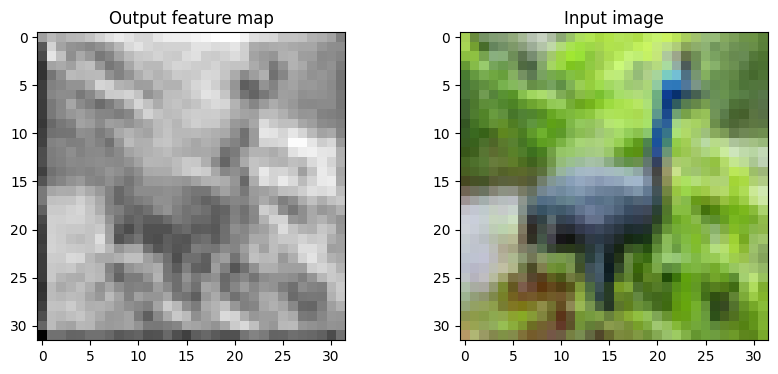

In [7]:
plot_comparison(output, img)

In [8]:
with torch.no_grad(): 
    conv.bias.zero_()

with torch.no_grad(): 
    conv.weight.fill_(1.0 / 9.0)

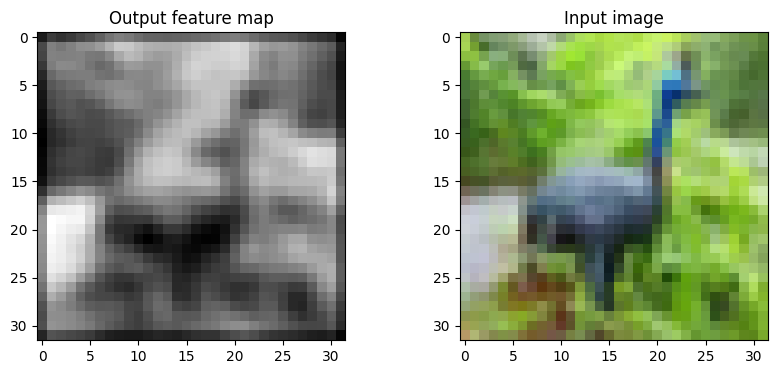

In [9]:
output = conv(img.unsqueeze(0))
plot_comparison(output, img)

In [10]:
with torch.no_grad(): 
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

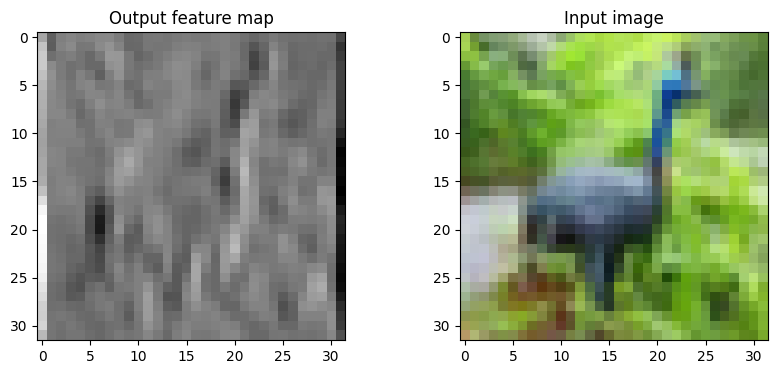

In [11]:
output = conv(img.unsqueeze(0))
plot_comparison(output, img)

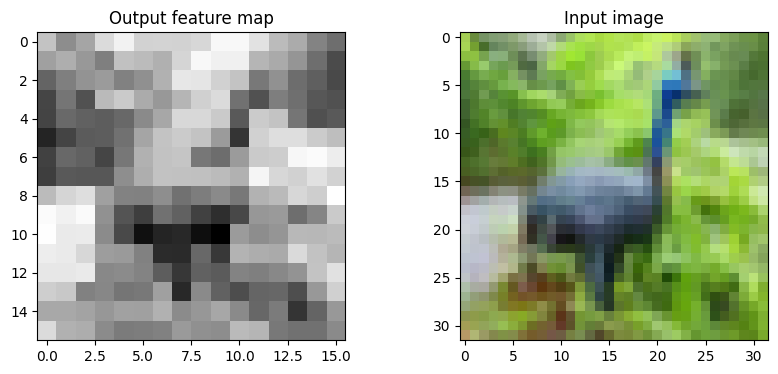

In [12]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

plot_comparison(output, img)

In [13]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.Tanh(), 
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.Tanh(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(8 * 8 * 8, 32),
    nn.Tanh(),
    nn.Linear(32, 2)
)

In [14]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [15]:
model(img.unsqueeze(0))

tensor([[-0.0080,  0.0324]], grad_fn=<AddmmBackward0>)

In [22]:
class Net(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [23]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0932,  0.0574]], grad_fn=<AddmmBackward0>)

In [24]:
import datetime 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader): 
    for epoch in range(1, n_epochs + 1): 
        loss_train = .0 
        for imgs, labels in train_loader: 
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad() 
            loss.backward() 
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0: 
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [25]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()
training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2024-07-31 08:37:32.666616 Epoch 1, Training loss 0.6898978754972956
2024-07-31 08:37:40.042126 Epoch 10, Training loss 0.4378488861071836
2024-07-31 08:37:48.156694 Epoch 20, Training loss 0.350803699083389
2024-07-31 08:37:56.279611 Epoch 30, Training loss 0.32388487667035143
2024-07-31 08:38:04.386815 Epoch 40, Training loss 0.3036609917499457
2024-07-31 08:38:12.732099 Epoch 50, Training loss 0.28741097032644186
2024-07-31 08:38:21.541286 Epoch 60, Training loss 0.27012114986112923
2024-07-31 08:38:30.472141 Epoch 70, Training loss 0.2573035535918679
2024-07-31 08:38:39.596342 Epoch 80, Training loss 0.24343890791675846
2024-07-31 08:38:48.580111 Epoch 90, Training loss 0.23386141064630192
2024-07-31 08:38:57.574357 Epoch 100, Training loss 0.22205496797705912


In [26]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader): 
    for name, loader in [("train", train_loader), ("val", val_loader)]: 
        correct = 0 
        total = 0 
        with torch.no_grad(): 
            for imgs, labels in loader: 
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.91
Accuracy val: 0.89


In [66]:
data_path = "./"
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [28]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

In [59]:
mismatches = []
for i, (img, label) in enumerate(cifar2_val):
    output = loaded_model(img.unsqueeze(0))
    _, predicted = torch.max(output, dim=1)
    if predicted != label:
        mismatches.append(i)

# Plot the mismatches
# for i in mismatches:
#     img, label = cifar2_val[i]
#     output = loaded_model(img.unsqueeze(0))
#     _, predicted = torch.max(output, dim=1)
#     class_names = ['airplane', 'bird']
#     plt.imshow(img.permute(1, 2, 0))
#     plt.xlabel("Predicted: {}, Actual: {}".format(class_names[predicted[0].item()], class_names[label]))
#     # plt.show()

In [64]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader): 
    for epoch in range(1, n_epochs + 1): 
        loss_train = .0
        for imgs, labels in train_loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0: 
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

Training on device cuda.


In [65]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs=100, optimizer=optimizer, model=model, loss_fn=loss_fn, train_loader=train_loader)

2024-07-31 08:56:36.436171 Epoch 1, Training loss 0.6883292448748449
2024-07-31 08:56:38.569478 Epoch 10, Training loss 0.48199020886117483
2024-07-31 08:56:40.945261 Epoch 20, Training loss 0.388654600852614
2024-07-31 08:56:43.292081 Epoch 30, Training loss 0.3436467339088962
2024-07-31 08:56:45.666518 Epoch 40, Training loss 0.32420619173794035
2024-07-31 08:56:48.051510 Epoch 50, Training loss 0.3043301422504862
2024-07-31 08:56:50.501224 Epoch 60, Training loss 0.2881592563383139
2024-07-31 08:56:53.038934 Epoch 70, Training loss 0.2749151989437972
2024-07-31 08:56:55.488377 Epoch 80, Training loss 0.26365560051172404
2024-07-31 08:56:57.881860 Epoch 90, Training loss 0.24994398454192338
2024-07-31 08:57:00.252486 Epoch 100, Training loss 0.23897747434438413


In [67]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt', map_location=device))

<All keys matched successfully>

In [72]:
class NetWidth(nn.Module): 
    def __init__(self, n_chans1=32): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        # self.covn1_dropout = nn.Dropout2d(p=0.4)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        # self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(n_chans1 // 2 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
    
    # def forward(self, x): 
    #     out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
    #     oupt = self.conv1_dropout(out)
    #     out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
    #     out = self.conv2_dropout(out)
    #     out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
    #     out = torch.tanh(self.fc1(out))
    #     out = self.fc2(out)
    #     return out

    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, self.n_chans1 // 2 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out


In [69]:
sum(p.numel() for p in NetWidth().parameters())

38386

In [70]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader): 
    for epoch in range(1, n_epochs + 1): 
        loss_train = .0 
        for imgs, labels in train_loader: 
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            l2_lambda = .001 
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0: 
            print("{} Epoch {}, Training loss {}".format(
                datetime.datetime.now(), epoch, loss_train/len(train_loader)))

In [73]:
class ResBlock(nn.Module): 
    def __init__(self, n_chans): 
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
    
    def forward(self, x): 
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x
    
class NetResDeep(nn.Module): 
    def __init__(self, n_chans1=32, n_blocks=10): 
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)])
        )
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
    
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [88]:
for name, param in model.named_parameters(): 
    print(name, param.shape)

conv1.weight torch.Size([16, 3, 3, 3])
conv1.bias torch.Size([16])
conv2.weight torch.Size([8, 16, 3, 3])
conv2.bias torch.Size([8])
fc1.weight torch.Size([32, 512])
fc1.bias torch.Size([32])
fc2.weight torch.Size([2, 32])
fc2.bias torch.Size([2])


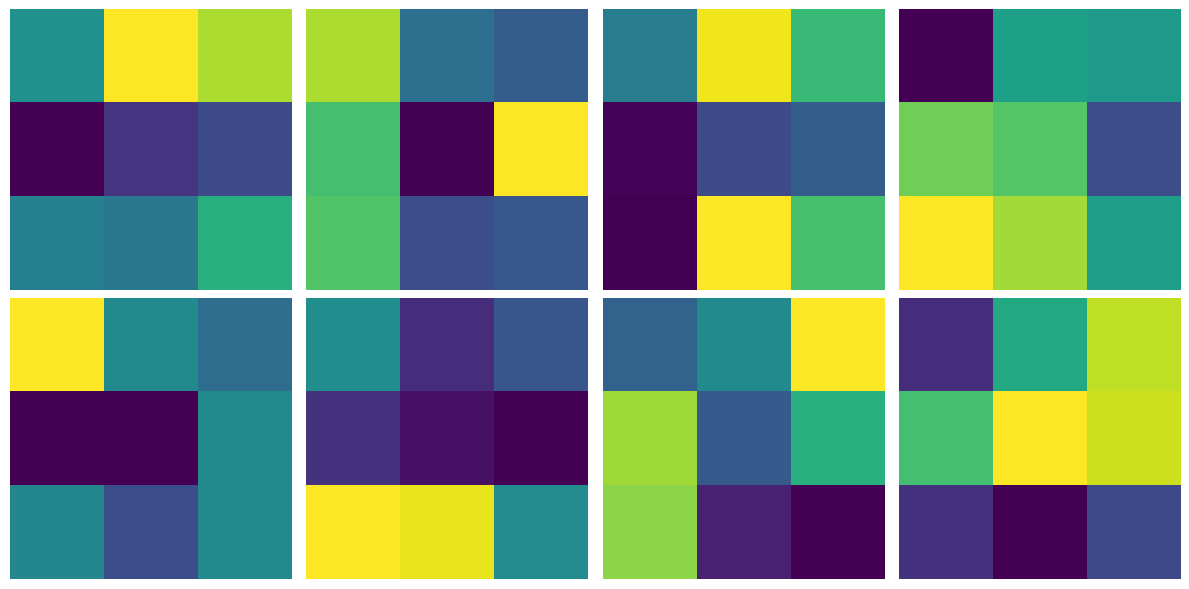

In [92]:
weights = model.conv2.weight.detach().cpu()
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
for i, weight in enumerate(weights):
    ax = axs[i // 4, i % 4]
    ax.imshow(weight[0])
    ax.axis('off')
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

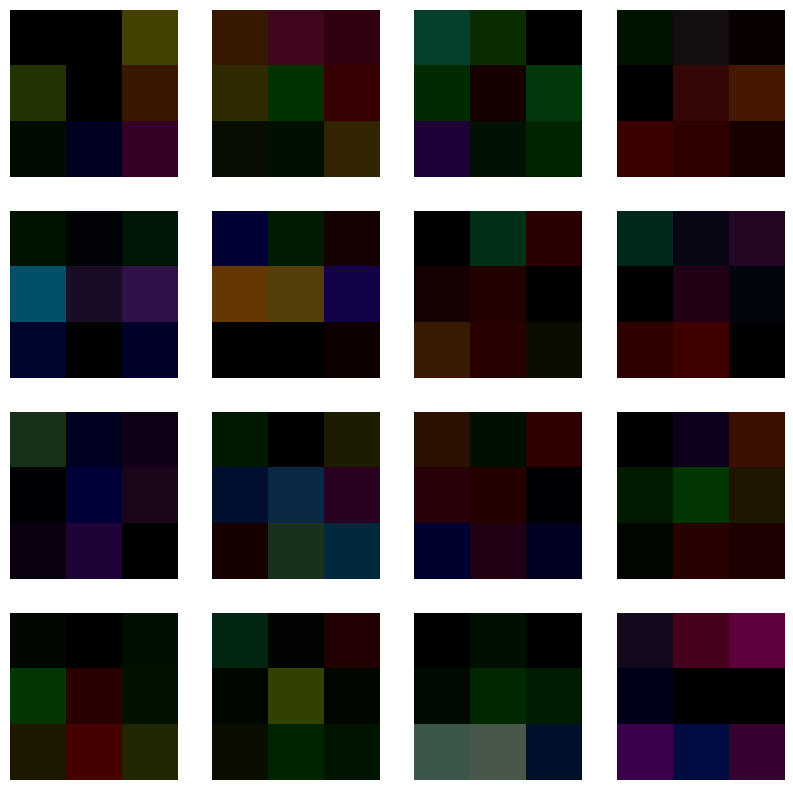

In [84]:
import matplotlib.pyplot as plt

weights = model.conv2.weight.detach().cpu()

fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(weights[i].permute(1, 2, 0))
    ax.axis('off')

plt.show()

torch.Size([16, 3, 3, 3])